# Working with CT whole-body dataset

In [1]:
#For working wit Nifti file images on python-ipynb we need some new libraries
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from simulate_mri.Volume import Volume
# Here we import the parent class to work with the CT labeled file

In [3]:
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress = True)

In [4]:
# Loading the final segmentation with fat/muscle around the body
ct_wb_seg = nib.load("post_processing/final_sc_seg.nii.gz")
# This variables are instances of the nibabel image
# To work with the data we can get the numpy data:
labels = ct_wb_seg.get_fdata()
labels.shape


(400, 400, 326)

In [5]:
# A util function to sow slices 
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

Text(0.5, 0.98, 'Center slices for CT-WB segmentated')

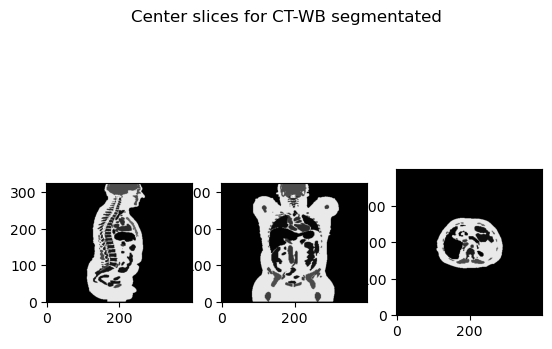

In [6]:
slice_0 = labels[200, :, :]
slice_1 = labels[:, 200, :]
slice_2 = labels[:, :, 163]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for CT-WB segmentated") 
# To see it better it is recommended to use ITK snap and use the label colors provided (see README file)

## Susceptibility Phantom Creation

In [7]:
# Now we can create a volume class and start seeing the methods from it!
new_vol = Volume(ct_wb_seg)


Total Segmentator should always output the same label ids for the different parts of the body its been trained to segment. </br>
We can use this to our advantage and pre-define label ids with names and known susceptibility values from the literature. </br>
Under the hood when the object is created a unique labels array is created and it auto-calls a method to instance a label for each label id.
After every label is created, the method create_segmentation_labels automatically groups the labels into their respective susceptibility values, for example, label 76 will always be Spinal Canal. Some labels from TotalSegmentator point to the same body part, like lungs cover labels 9 through 13. All the bones are grouped into the same category and given the same name and susceptibility value. The organs are given the susceptibility value of water and organs of interest retain their names (because later on, we want to give this labels different relaxation times) such as liver, spleen, heart, brain, kidney, trachea, glands and esophagus. </br>


In [8]:
new_vol.create_segmentation_labels()
# This is the first method we call

Now as easy as 1 line of code, we can create a susceptibility distribution phantom from the input CT Nifti file </br>
It retains the shape and structure of the real CT whole body. 

In [9]:
%%time
sus_dist = new_vol.create_sus_dist()

CPU times: total: 4.45 s
Wall time: 16.8 s


By default the susceptibility distribution will be stored as a numpy array but we can also save it as a Nifti Image </br>
Don't worry if you can't see the file at first glance. The code will automatically create an output folder and put it there for you!

In [10]:
new_vol.save_sus_dist_nii()
#Saving the susceptibility distribution to Nifti

In [11]:
# We can save all he susceptibility values used for the phantom creation
# And export them as csv 
new_vol.save_sus_csv()

## Optimized Simultion of MRI acquisition

As mentioned in the README file, we will use the susceptibility distribution to calculate the frequency shift needed in the simulation equation:

$$ \text{protonDensity} \cdot \sin(\text{FA}) \cdot \exp\left(-\frac{TE}{T2^*} - \text{sign} \cdot i \cdot \gamma \cdot \delta B_0 \cdot TE\right) $$

In [11]:
%%time
# Testing the new optimized method
# This method automatically creates the PD and T2star volumes
# It reduces the iteration process
TE_list = [0.008, 0.0095, 0.011, 0.0125, 0.014, 0.0155]
flip_ang = 24
new_vol.optimize_measurement(flip_ang, TE_list)

CPU times: total: 27.4 s
Wall time: 1min 16s


In [12]:
new_vol.get_Magnitude()
new_vol.get_Phase()

# Step by step Simulation of MRI


In [11]:
%%time
# For that we need to calculate the frequency shift
new_vol.calculate_deltaB0()

CPU times: total: 1.19 s
Wall time: 6.68 s


As we have create a new volume, it is good if we could see it as well! </br>
It is also a fun thing to see because now we will have varying values in every voxel due to the nature of the convolution with the dipole kernel

In [12]:
new_vol.save_deltaB0()

In [ ]:
%%time
new_vol.create_t2_star_vol()

In [13]:
%%time
TE_list = [0.008, 0.0095, 0.011, 0.0125, 0.014, 0.0155]
flip_ang = 24

new_vol.simulate_measurement(flip_ang,TE_list)


CPU times: total: 4min 2s
Wall time: 24min 6s


In [14]:
new_vol.get_Magnitude()
new_vol.get_Phase()